In [2]:
import sys
import os
sys.path.append(os.curdir + "/..") # import util

import numpy as np
import itertools as it
from fractions import Fraction
from math import floor, ceil, factorial, log10
from scipy.special import binom
from multiprocessing import Pool
from libqif.core.secrets import Secrets
from libqif.core.channel import Channel
from libqif.core.hyper import Hyper
from libqif.core.gvulnerability import Gain
import matplotlib.pyplot as plt
from util import float_equal
from tqdm import tqdm
from termcolor import colored
import pandas as pd
from binary import ModelBinary
from binaryt import ModelBinaryTarget

In [3]:
df = pd.DataFrame(columns=['n','m','prior','post'])
for n in np.arange(1,17):
    for m in np.arange(1,n+1):
        model = ModelBinary(n, m)
        prior, post = model.prior_vul(), model.post_vul()
        df.loc[-1] = [n,m,prior,post]
        df = df.reset_index(drop=True)
        # df = pd.concat([df, {'n':n, 'm':m, 'prior':prior, 'post':post}], ignore_index=True)
df = df.groupby(['n','m']).sum()
# df

KeyboardInterrupt: 

In [ ]:
dfp = pd.DataFrame(columns=['n','m','prior','post'])
for n in np.arange(1,17):
    for m in np.arange(1,n+1):
        prior, post = 1/2, ModelBinaryTarget.post_vul_eq((n,m,'in'))
        dfp.loc[-1] = [n,m,prior,post]
        dfp = dfp.reset_index(drop=True)
        # dfp = pd.concat([dfp, {'n':n, 'm':m, 'prior':prior, 'post':post}], ignore_index=True)
dfp = dfp.groupby(['n','m']).sum()
dfp

prior      post
n    m                    
1.0  1.0     0.5  1.000000
2.0  1.0     0.5  1.000000
     2.0     0.5  0.833333
3.0  1.0     0.5  1.000000
     2.0     0.5  0.833333
...          ...       ...
16.0 12.0    0.5  0.769231
     13.0    0.5  0.769231
     14.0    0.5  0.766667
     15.0    0.5  0.766667
     16.0    0.5  0.764706

[136 rows x 2 columns]

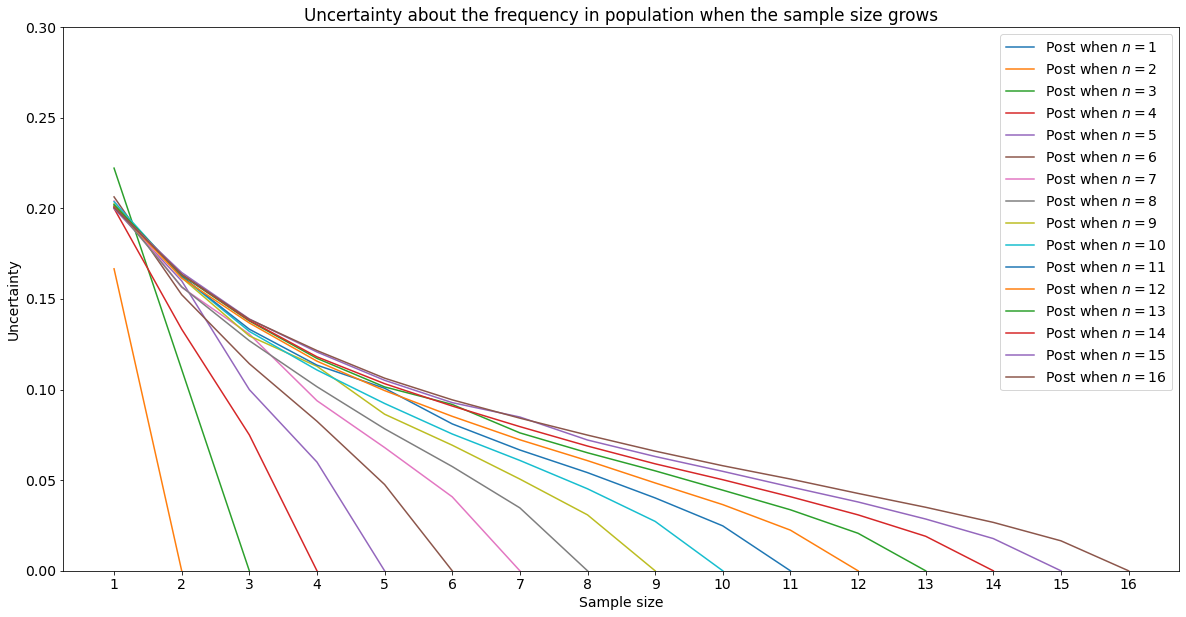

In [ ]:
font = {
    "size": 14,
}
plt.rc('font', **font)
plt.figure(figsize=(20,10))

def plot(n):
    # plt.plot(list(range(1,n+1)), df.loc[n]['prior'], label='Prior when $n=%d$'%(n))
    plt.plot(list(range(1,n+1)), df.loc[n]['post'], label='Post when $n=%d$'%(n))

plt.title('Uncertainty about the frequency in population when the sample size grows')
plt.xlabel('Sample size')
plt.ylabel('Uncertainty')
plt.xticks(list(range(1,n+1)))
plt.ylim((0, 0.3))
for n in list(range(1,17)):
    plot(n)

plt.legend()
plt.show()

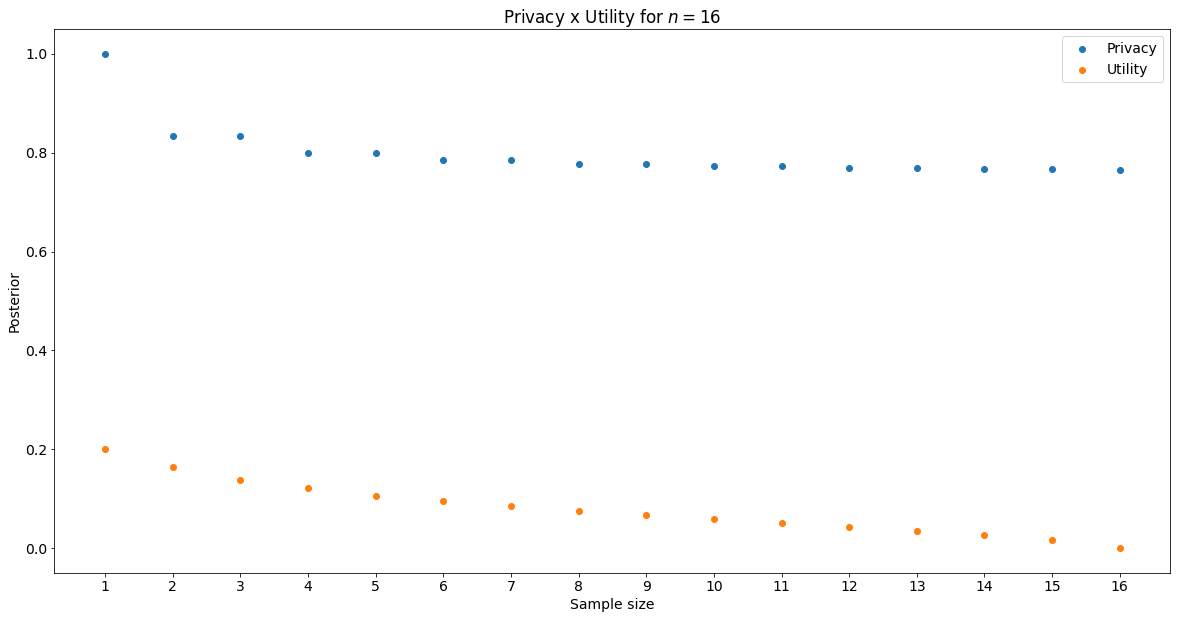

In [ ]:
font = {
    "size": 14,
}
plt.rc('font', **font)
plt.figure(figsize=(20,10))

def plot(n):
    plt.scatter(list(range(1,n+1)), dfp.loc[n]['post'], label='Privacy')
    plt.scatter(list(range(1,n+1)), df.loc[n]['post'], label='Utility')

plt.title('Privacy x Utility for $n=%d$'%(n))
plt.xlabel('Sample size')
plt.ylabel('Posterior')
plt.xticks(list(range(1,n+1)))
# plt.ylim((0, 0.3))
for n in [16]:
    plot(n)

plt.legend()
plt.show()

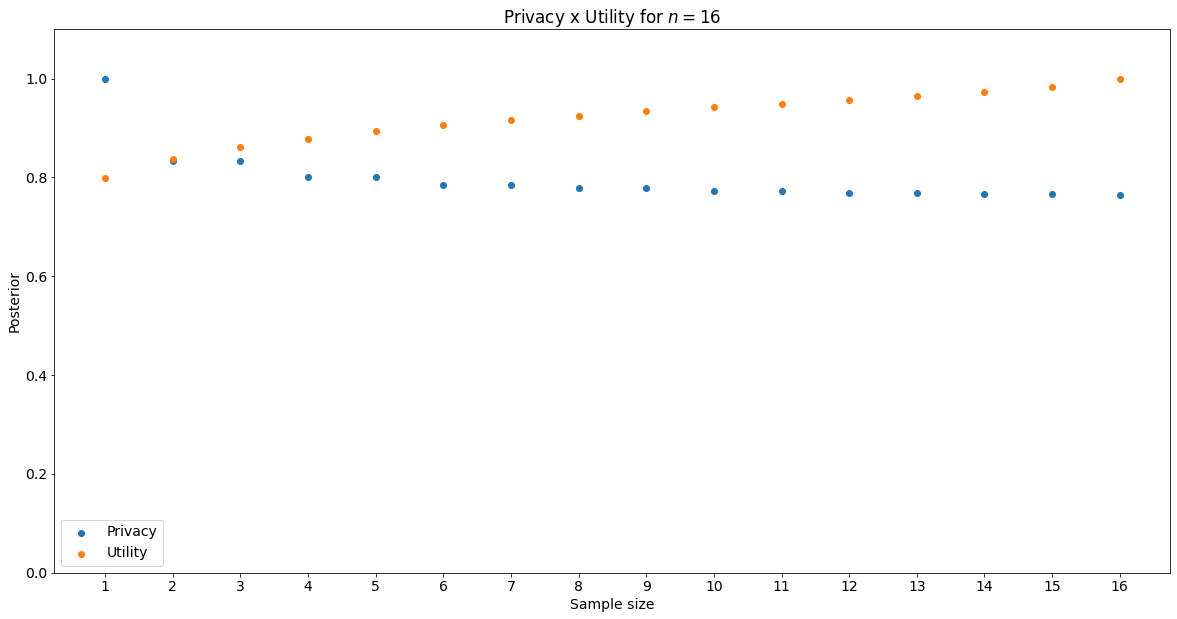

In [ ]:
font = {
    "size": 14,
}
plt.rc('font', **font)
plt.figure(figsize=(20,10))

def plot(n):
    plt.scatter(list(range(1,n+1)), dfp.loc[n]['post'], label='Privacy')
    plt.scatter(list(range(1,n+1)), 1-np.array(df.loc[n]['post']), label='Utility')

plt.title('Privacy x Utility for $n=%d$'%(n))
plt.xlabel('Sample size')
plt.ylabel('Posterior')
plt.xticks(list(range(1,n+1)))
plt.ylim((0, 1.1))
for n in [16]:
    plot(n)

plt.legend()
plt.show()

In [ ]:
def f(k,n,m,y):
    s = 0
    for yp in np.arange(n-m+1):
        s = s + (binom(m,y)*binom(n-m,yp)*abs(k-y-yp))/binom(n,y+yp)
    return s

In [ ]:
df = pd.DataFrame(columns=['n','m','y'])
maxn = 10
for n in np.arange(1,maxn+1):
    for m in np.arange(1,n+1):
        for y in np.arange(m+1):
            df.loc[len(df.index)] = [n,m,y]
                
df['min'] = df.apply(lambda row : np.array([f(k,row.n,row.m,row.y) for k in np.arange(row.n+1)]).min(), axis=1)
df['argmin'] = df.apply(lambda row : np.array([f(k,row.n,row.m,row.y) for k in np.arange(row.n+1)]).argmin(), axis=1)
for k in np.arange(n+1):
    df["k=%d"%(k)] = df.apply(lambda row : f(k,row.n,row.m,row.y) if k<=row.n else '-', axis=1)
pd.set_option('display.max_rows', None)

In [ ]:
pd.options.display.float_format = '{:,.3f}'.format
# df[df['n'] == 4]
df.to_csv('post_vul_utility.csv', float_format='%.3f', index=False)

In [4]:
def eq(n,m,y,k):
    s = 0
    for yp in np.arange(n-m+1):
        s = s + (binom(m,y) * binom(n-m,yp) * abs(k-y-yp))/ binom(n,y+yp)
    return s

In [7]:
n = 16
m = 2
mink = []
ms = []
ys = []
for m in np.arange(1,n+1):
    ms += [m]*(m+1)
    ys += list(np.arange(m+1))
    for y in np.arange(m+1):
        mink.append(np.array([eq(n,m,y,k) for k in np.arange(n+1)]).argmin())

df = pd.DataFrame({'m':ms, 'y':ys, 'min k':mink})
df = df.groupby(['m','y','min k']).sum()
pd.set_option('display.max_rows', len(df))
df

# for k in np.arange(n+1):
#     print('\tk =',k, "=>>", '%.4f'%(eq(n,m,y,k)), ',', Fraction(eq(n,m,y,k)))

Empty DataFrame
Columns: []
Index: [(1, 0, 4), (1, 1, 12), (2, 0, 3), (2, 1, 8), (2, 2, 13), (3, 0, 2), (3, 1, 6), (3, 2, 10), (3, 3, 14), (4, 0, 1), (4, 1, 5), (4, 2, 8), (4, 3, 11), (4, 4, 15), (5, 0, 1), (5, 1, 4), (5, 2, 7), (5, 3, 9), (5, 4, 12), (5, 5, 15), (6, 0, 1), (6, 1, 3), (6, 2, 6), (6, 3, 8), (6, 4, 10), (6, 5, 13), (6, 6, 15), (7, 0, 1), (7, 1, 3), (7, 2, 5), (7, 3, 7), (7, 4, 9), (7, 5, 11), (7, 6, 13), (7, 7, 15), (8, 0, 0), (8, 1, 2), (8, 2, 4), (8, 3, 6), (8, 4, 8), (8, 5, 10), (8, 6, 12), (8, 7, 14), (8, 8, 16), (9, 0, 0), (9, 1, 2), (9, 2, 4), (9, 3, 5), (9, 4, 7), (9, 5, 9), (9, 6, 11), (9, 7, 12), (9, 8, 14), (9, 9, 16), (10, 0, 0), (10, 1, 2), (10, 2, 3), (10, 3, 5), (10, 4, 6), (10, 5, 8), (10, 6, 10), (10, 7, 11), (10, 8, 13), (10, 9, 14), (10, 10, 16), (11, 0, 0), (11, 1, 2), (11, 2, 3), (11, 3, 4), (11, 4, 6), (11, 5, 7), (11, 6, 9), (11, 7, 10), (11, 8, 12), (11, 9, 13), (11, 10, 14), (11, 11, 16), (12, 0, 0), (12, 1, 1), (12, 2, 3), (12, 3, 4), (12, 4, 5), (12, 5, 7), (12, 6, 8), (12, 7, 9), (12, 8, 11), (12, 9, 12), (12, 10, 13), (12, 11, 15), (12, 12, 16), (13, 0, 0), (13, 1, 1), (13, 2, 2), (13, 3, 4), (13, 4, 5), (13, 5, 6), (13, 6, 7), (13, 7, 9), (13, 8, 10), (13, 9, 11), ...]

In [79]:
m_range = [1]
n_range = range(10,101,10)
ns, ms, ys, mink = [], [], [], []

for n in n_range:
    ns = ns + [n]*4
    ms = ms + [3,3,3,3]
    ys = ys + [0,1,2,3]
    mink.append(np.array([eq(n,3,0,k) for k in np.arange(n+1)]).argmin())
    mink.append(np.array([eq(n,3,1,k) for k in np.arange(n+1)]).argmin())
    mink.append(np.array([eq(n,3,2,k) for k in np.arange(n+1)]).argmin())
    mink.append(np.array([eq(n,3,3,k) for k in np.arange(n+1)]).argmin())

df = pd.DataFrame({'n':ns, 'm':ms, 'y':ys, 'min k':mink})
df = df.groupby(['n', 'm','y','min k']).sum()
df

Empty DataFrame
Columns: []
Index: [(10, 3, 0, 1), (10, 3, 1, 4), (10, 3, 2, 6), (10, 3, 3, 9), (20, 3, 0, 3), (20, 3, 1, 8), (20, 3, 2, 12), (20, 3, 3, 17), (30, 3, 0, 4), (30, 3, 1, 11), (30, 3, 2, 19), (30, 3, 3, 26), (40, 3, 0, 6), (40, 3, 1, 15), (40, 3, 2, 25), (40, 3, 3, 34), (50, 3, 0, 7), (50, 3, 1, 19), (50, 3, 2, 31), (50, 3, 3, 43), (60, 3, 0, 9), (60, 3, 1, 23), (60, 3, 2, 37), (60, 3, 3, 51), (70, 3, 0, 11), (70, 3, 1, 27), (70, 3, 2, 43), (70, 3, 3, 59), (80, 3, 0, 12), (80, 3, 1, 31), (80, 3, 2, 49), (80, 3, 3, 68), (90, 3, 0, 14), (90, 3, 1, 35), (90, 3, 2, 55), (90, 3, 3, 76), (100, 3, 0, 15), (100, 3, 1, 38), (100, 3, 2, 62), (100, 3, 3, 85)]